Автор: Лейман М.А.   
Дата создания: 22.03.2025  

# Задание ZALA  







## 1. Обработка датасета UAVOD

### Классы датасета  
'building': 0,      		здание  
'cable-tower': 1, 		кабельная вышка  
'cultivation-mesh-cage': 2,  	сетка для выращивания  
'landslide': 3, 		оползень  
'pool': 4, 			бассейн  
'prefabricated-house': 5, 	сборный-дом"  
'quarry': 6,			карьер  
'ship': 7, 			корабль  
'vehicle': 8,			транспортное средство  
'well': 9			колодец  



In [1]:
# Названия классов
class_names = ["building", "cultivation-mesh-cage", "landslide",
               "pool", "prefabricated-house", "quarry", "ship", "vehicle", "well"]


class_names2 = ["здание", "сетка для выращивания", "оползень",
               "бассейн", "сборный-дом", "карьер", "корабль", "транспортное средство", "колодец"]

### Преобразование датасета в формат YOLO

In [2]:
import os
import xml.etree.ElementTree as ET

# Получаем текущую рабочую папку  
current_directory = os.getcwd()  

path_dataset = os.path.join(current_directory, "dataset")

target_original = 'dataset_UAVOD/datasets_original/target/'    # таргеты XML
xml_dir = os.path.join(path_dataset, target_original)  

image_original = 'dataset_UAVOD/datasets_original/image/'    # Исходные изображения
image_dir = os.path.join(path_dataset, image_original)  

target_yolo_original = 'dataset_UAVOD/datasets_original/target_yolo/'    # YOLO разметка
output_txt_dir = os.path.join(path_dataset, target_yolo_original) 

print("Текущая папка:", current_directory)  
print("Датасет:      ", path_dataset)  
print("Таргет:       ", xml_dir)  
print("Изображения:  ", image_dir)  
print("Таргет YOLO:  ", output_txt_dir)  



Текущая папка: /home/maksim/develops/python/devsTraining/zala_task
Датасет:       /home/maksim/develops/python/devsTraining/zala_task/dataset
Таргет:        /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/datasets_original/target/
Изображения:   /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/datasets_original/image/
Таргет YOLO:   /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/datasets_original/target_yolo/


In [3]:
os.makedirs(output_txt_dir, exist_ok=True)

def convert_voc_to_yolo(xml_file, output_dir):
    """ 
        Конвертирует датасет в YOLO формат
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Получаем размеры изображения
    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)

    yolo_labels = []
    for obj in root.findall("object"):
        class_name = obj.find("name").text
        if class_name not in class_names:
            continue
        class_id = class_names.index(class_name)

        bbox = obj.find("bndbox")
        xmin, ymin, xmax, ymax = map(int, [bbox.find("xmin").text, bbox.find("ymin").text,
                                           bbox.find("xmax").text, bbox.find("ymax").text])

        # Перевод координат в нормализованные
        x_center = (xmin + xmax) / (2 * width)
        y_center = (ymin + ymax) / (2 * height)
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        yolo_labels.append(f"{class_id} {x_center} {y_center} {bbox_width} {bbox_height}")

    # Сохранение  в файл
    filename = os.path.basename(xml_file).replace(".xml", ".txt")
    with open(os.path.join(output_dir, filename), "w") as f:
        f.write("\n".join(yolo_labels))

def convert_annotation():
    # Обрабатываем все XML
    for xml_file in os.listdir(xml_dir):
        if xml_file.endswith(".xml"):
            convert_voc_to_yolo(os.path.join(xml_dir, xml_file), output_txt_dir)

    print("Конвертация завершена!")

# convert_annotation()  

### Количество объектов по классам

In [4]:
import glob

label_paths = glob.glob(f"{output_txt_dir}*.txt")
class_counts = {}

for label_path in label_paths:
    with open(label_path, "r") as file:
        lines = file.readlines()
    
    for line in lines:
        parts = line.split()
        if parts:  # Если строка не пустая
            class_id = int(parts[0])  # Получаем class_id
            class_counts[class_id] = class_counts.get(class_id, 0) + 1  # Считаем

print("Количество объектов по классам:")
# Вывод  классов и их количества
for class_id, count in sorted(class_counts.items()):
    print(f"Класс {class_id}: {count} объектов")

Количество объектов по классам:
Класс 0: 12662 объектов
Класс 2: 263 объектов
Класс 3: 40 объектов
Класс 4: 49 объектов
Класс 5: 2027 объектов
Класс 6: 83 объектов
Класс 7: 771 объектов
Класс 8: 466 объектов
Класс 9: 677 объектов


####  Объединение классов  

Классы 3, 4, 6  малочисленны,  удалим их 

In [5]:
import os
from glob import glob
def cleaned1(class_map, remove_classes, input_dir):
    output_dir = "cleaned_labels"
    os.makedirs(output_dir, exist_ok=True)


    # ======================       Обработка всех .txt файлов 
    label_files = glob(os.path.join(input_dir, "*.txt"))
    print(f"Найдено {len(label_files)} файлов для обработки.")

    for path in label_files:
        with open(path, "r") as f:
            lines = f.readlines()

        new_lines = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue

            class_id = int(parts[0])
            if class_id in remove_classes:
                continue
            elif class_id in class_map:
                parts[0] = str(class_map[class_id])
                new_lines.append(" ".join(parts))
            else:
                new_lines.append(" ".join(parts)) 

        filename = os.path.basename(path)
        output_path = os.path.join(output_dir, filename)
        with open(output_path, "w") as f:
            f.write("\n".join(new_lines) + "\n")

        print(f"✔ Сохранён: {output_path}")

    print("Готово: все обновлённые разметки сохранены в cleaned_labels/")


# ===============    Словарь  классов для переименования
class_map = {
    533: 0,
}

# =======================     Классы, которые удаляем 
remove_classes = {3, 4, 6}
input_dir = "/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_full_3/labels/val/"

# cleaned1(class_map, remove_classes, input_dir)

In [6]:
import glob

path = "/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/dataset_orign_2/target/"

label_paths = glob.glob(f"{path}*.txt")
class_counts = {}
for label_path in label_paths:
    with open(label_path, "r") as file:
        lines = file.readlines()
    
    for line in lines:
        parts = line.split()
        if parts:  # Если строка не пустая
            class_id = int(parts[0])  # Получаем class_id
            class_counts[class_id] = class_counts.get(class_id, 0) + 1  # Считаем

print("Количество объектов по классам:")
# Вывод  классов и их количества
for class_id, count in sorted(class_counts.items()):
    print(f"Класс {class_id}: {count} объектов")

Количество объектов по классам:
Класс 0: 15570 объектов
Класс 2: 272 объектов
Класс 3: 1 объектов
Класс 4: 745 объектов
Класс 6: 567 объектов
Класс 7: 805 объектов


In [7]:
import os

def find_images_with_class(label_dir, target_class=3):
    matched_files = []
    for filename in sorted(os.listdir(label_dir)):
        if not filename.endswith('.txt'):
            continue

        path = os.path.join(label_dir, filename)
        with open(path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) > 0 and int(parts[0]) == target_class:
                    matched_files.append(filename.replace('.txt', '.jpg'))  # или .png
                    break  # нашли класс — достаточно, переходим к следующему файлу
    return matched_files



In [8]:
label_dir = "/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/dataset_orign_2/target/"
target_class = 3
files = find_images_with_class(label_dir, target_class)

print(f"Найдено {len(files)} изображений с классом {target_class}:")
for f in files:
    print(f)


Найдено 1 изображений с классом 3:
278.jpg


### Разделение датасета  
train  
val  
test  


In [9]:
import os
import shutil
import random

images_path = image_dir  

labels_path = output_txt_dir



def splitting_dataset(image_dir=images_path, label_dir=labels_path ):
    """ 
        Разделяет датасет
    """

    # Пути для разделённых данных
    output_dirs = {
        "train": ("dataset/dataset_UAVOD/datasets_split/images/train", "dataset/dataset_UAVOD/datasets_split/labels/train"),
        "val": ("dataset/dataset_UAVOD/datasets_split/images/val", "dataset/dataset_UAVOD/datasets_split/labels/val"),
        "test": ("dataset/dataset_UAVOD/datasets_split/images/test", "dataset/dataset_UAVOD/datasets_split/labels/test"),
    }

    for dirs in output_dirs.values():
        os.makedirs(dirs[0], exist_ok=True) 
        os.makedirs(dirs[1], exist_ok=True)  

    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])

    random.shuffle(image_files)

    train_split = int(0.75 * len(image_files))
    val_split = int(0.85 * len(image_files))

    splits = {
        "train": image_files[:train_split],
        "val": image_files[train_split:val_split],
        "test": image_files[val_split:],
    }

    for split, files in splits.items():
        img_out, lbl_out = output_dirs[split]

        for file in files:
            shutil.copy(os.path.join(image_dir, file), os.path.join(img_out, file))

            label_file = os.path.splitext(file)[0] + ".txt"
            if os.path.exists(os.path.join(label_dir, label_file)):
                shutil.copy(os.path.join(label_dir, label_file), os.path.join(lbl_out, label_file))

    print("Датасет успешно разделён!")


In [10]:
image_original = 'dataset_UAVOD/dataset_orign_2/image/'    # Исходные изображения
images_path = os.path.join(path_dataset, image_original)  

target_yolo_original = 'dataset_UAVOD/dataset_orign_2/target/'   
labels_path = os.path.join(path_dataset, target_yolo_original) 

# splitting_dataset(image_dir=images_path, label_dir=labels_path)

#### Баланс классов 

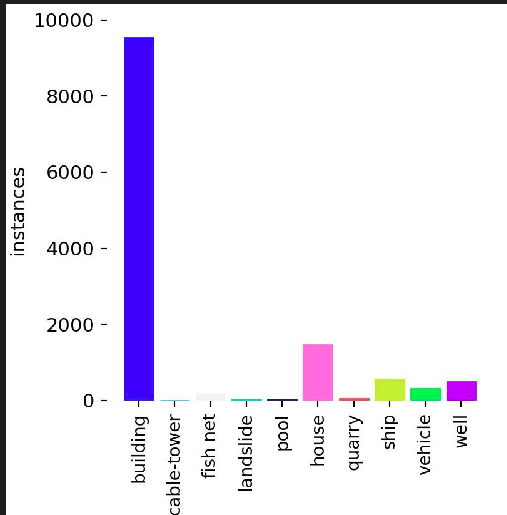

#### Как видно из графика в датасете  больше всего зданий класс 0, нужно увеличить количество других классов  
Увеличим колличество классов аугментируя изображения  где есть классы кроме 0!  
Объеденим классы 0 и 5  

### Объединение классов 

In [11]:


# ===============    Словарь  классов для переименования
class_map = {
    5: 0,
}

# =======================     Классы, которые удаляем 
remove_classes = {3, 4, 6}
input_dir = "/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/datasets_original/target_yolo/"
input_dir = "/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_full_2/labels/train/"
# cleaned1(class_map, remove_classes, input_dir)



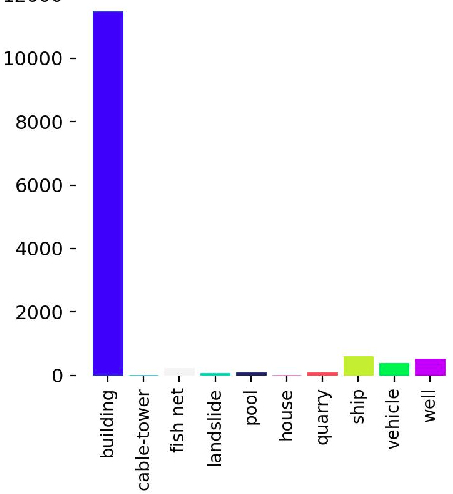  


### Аугментация  1.

аугментируем тренировочный набор  

Увеличим колличество классов аугментируя изображения  где есть классы кроме 0!  

In [12]:
import cv2
import numpy as np

def resize_with_padding(image, boxes, target_size=1024):
    """
        Уменьшает изображение с сохранением пропорций, добавляя паддинг до target_size.   
        Изменяет  boxes под новое изображение. 
        
        image: исходное изображение (HWC)  
        boxes: bboxes в формате [x_min, y_min, x_max, y_max] в абсолютных координатах  
        target_size: желаемый размер изображения (квадратный)  
        return: новое изображение,  боксы  
    """
    orig_h, orig_w = image.shape[:2]

    # Масштаб
    scale = min(target_size / orig_w, target_size / orig_h)
    new_w = int(orig_w * scale)
    new_h = int(orig_h * scale)

    # Изменяем размер
    resized = cv2.resize(image, (new_w, new_h))

    # Паддинг
    pad_w = target_size - new_w
    pad_h = target_size - new_h
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left

    # Добавляем отступы (черный фон)
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0,0,0))

    # Корректируем координаты боксов
    boxes = np.array(boxes).astype(np.float32)
    boxes *= scale
    boxes[:, [0, 2]] += left   # x_min, x_max
    boxes[:, [1, 3]] += top    # y_min, y_max

    return padded, boxes



import cv2

def resize_with_min_side(image, min_side=1024):
    h, w = image.shape[:2]
    scale = max(min_side / h, min_side / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    return resized_image


def read_yolo_labels(label_path):
    boxes = []
    if not os.path.exists(label_path):
        return boxes

    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) != 5:
                continue  # Пропустить некорректные строки
            try:
                cls = int(parts[0])
                cx, cy, bw, bh = map(float, parts[1:])
                boxes.append([cls, cx, cy, bw, bh])
            except ValueError:
                continue  # Пропустить строки с неверными типами данных
    return boxes


def save_yolo_labels(output_path, boxes):
    with open(output_path, 'w') as f:
        for box in boxes:
            cls, cx, cy, bw, bh = box
            f.write(f"{cls} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}\n")


def convert_box_to_crop_coords(box, w, h):
    cls, cx, cy, bw, bh = box
    x = cx * w
    y = cy * h
    return int(x), int(y)


In [ ]:
# 
# Создаёт новые изображения (1024×1024) путём «перемешивания»
# объектов между кадрами. YOLO-разметка сохраняется.
# 
import os, random, glob, shutil, math
import cv2
import numpy as np
from typing import List, Tuple

# ПАРАМЕТРЫ 
SRC_IMG_DIR   = "/home/maksim/develops/python/devsTraining/zala_task/dataset/UNION_dataset/image/test/"        
SRC_LBL_DIR   = "/home/maksim/develops/python/devsTraining/zala_task/dataset/UNION_dataset/target/test/"
OUT_IMG_DIR   = "dataset/custom_dataset/mix_out/images"        
OUT_LBL_DIR   = "dataset/custom_dataset/mix_out/labels"

IMG_SIZE      = 1024                    # итоговый квадрат
CTX_MARGIN    = 8                       # паддинг вокруг bbox (px)
N_MIN, N_MAX  = 20, 100                 # требуемый диапазон объектов
OVERLAP_IOU   = 0.05                    # макс. IoU между вставками
SKIP_CLASSES  = {0, 2, 3, 4}            # какие классы НЕ переносим
patch_margin = 16                       # отступ от других объектов в пикселях
# SKIP_CLASSES  = {0} 

random.seed(42)

# ВСПОМОГАТЕЛЬНЫЕ 

def read_yolo(path: str) -> List[Tuple[int,float,float,float,float]]:
    """Читает YOLO-txt: cls cx cy w h  (нормированные)"""
    boxes = []
    if not os.path.exists(path):
        return boxes
    with open(path, "r") as f:
        for line in f:
            p = line.strip().split()
            if len(p) != 5: continue
            c, cx, cy, bw, bh = map(float, p)
            boxes.append((int(c), cx, cy, bw, bh))
    return boxes


def write_yolo(path: str, boxes):
    with open(path, "w") as f:
        for c, cx, cy, bw, bh in boxes:
            f.write(f"{c} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}\n")


def yolo2abs(cx, cy, bw, bh, W, H):
    """YOLO-норму → abs XYWH"""
    return (cx*W, cy*H, bw*W, bh*H)


def iou_xyxy(a, b):
    """IoU двух прямоугольников в xyxy"""
    x1 = max(a[0], b[0]);  y1 = max(a[1], b[1])
    x2 = min(a[2], b[2]);  y2 = min(a[3], b[3])
    inter = max(0, x2-x1) * max(0, y2-y1)
    area1 = (a[2]-a[0])*(a[3]-a[1])
    area2 = (b[2]-b[0])*(b[3]-b[1])
    return inter / (area1+area2-inter+1e-6)


def square_pad_resize(img):
    """до 1024*1024: либо центр-кроп, либо паддинг чёрным"""
    h, w = img.shape[:2]
    scale = IMG_SIZE / max(h, w)
    new_w, new_h = int(w*scale), int(h*scale)
    img_r = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    canvas = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
    off_x = (IMG_SIZE - new_w)//2
    off_y = (IMG_SIZE - new_h)//2
    canvas[off_y:off_y+new_h, off_x:off_x+new_w] = img_r
    return canvas, scale, off_x, off_y


def crop_with_margin(img, cx, cy, bw, bh, margin):
    """выдрать патч с контекстом и вернуть patch + bbox внутри patch"""
    h, w = img.shape[:2]
    x1 = int(cx - bw/2 - margin); y1 = int(cy - bh/2 - margin)
    x2 = int(cx + bw/2 + margin); y2 = int(cy + bh/2 + margin)
    x1, y1 = max(0,x1), max(0,y1)
    x2, y2 = min(w, x2), min(h, y2)
    patch = img[y1:y2, x1:x2].copy()
    # bbox координаты внутри патча:
    new_cx = (cx - x1) / (x2 - x1)
    new_cy = (cy - y1) / (y2 - y1)
    new_bw = bw / (x2 - x1)
    new_bh = bh / (y2 - y1)
    return patch, (new_cx, new_cy, new_bw, new_bh)

def expand_box(box, margin):
    x1, y1, x2, y2 = box
    return (x1 - margin, y1 - margin, x2 + margin, y2 + margin)


def is_clean_object(idx, boxes, ctx_margin):
    """
    Проверяем, не залезает ли контекст вокруг объекта `boxes[idx]`
    на соседние объекты.
    Возвращает True, если можно вырезать, False  если 
    окажется другой объект.
    """
    main_exp = expand_box(boxes[idx], ctx_margin)

    for j, other_box in enumerate(boxes):
        if j == idx:
            continue
        # пересекаются ли расширенные прямоугольник объекта и чужой бокс
        if iou_xyxy(main_exp, other_box) > 0:   # любая ненулевая площадь
            return False
    return True



def mix_img():
    # ОСНОВНАЯ ЛОГИКА 

    os.makedirs(OUT_IMG_DIR, exist_ok=True)
    os.makedirs(OUT_LBL_DIR, exist_ok=True)

    images = sorted(glob.glob(os.path.join(SRC_IMG_DIR, "*.jpg")))
    random.shuffle(images)

    n_imgs  = len(images)
    used_as_bg = set()               # не брать фон дважды
    cursor = 0                       # указатель - на источник патчей

    for bg_idx, bg_path in enumerate(images):
        if bg_idx in used_as_bg:
            continue

        lbl_path = os.path.join(SRC_LBL_DIR,
                                os.path.basename(bg_path).replace(".jpg", ".txt"))
        bg_boxes = read_yolo(lbl_path)

        # пропускаем, если объектов слишком много
        if len(bg_boxes) > N_MAX:
            continue



        # 1) читаем изображение для фона
        bg_img_raw = cv2.cvtColor(cv2.imread(bg_path), cv2.COLOR_BGR2RGB)
        H, W = bg_img_raw.shape[:2]

        # пропуск, если меньше 1024
        if H < IMG_SIZE or W < IMG_SIZE:
            continue

        # выбираем случайный кроп 1024x1024 из изображения для фона
        y0 = random.randint(0, H - IMG_SIZE)
        x0 = random.randint(0, W - IMG_SIZE)
        bg_img = bg_img_raw[y0:y0+IMG_SIZE, x0:x0+IMG_SIZE]

        # 2) Конвертируем  исходные YOLO-боксы
        scaled_bg_boxes = []
        placed_xyxy = []

        for cls, cx, cy, bw, bh in bg_boxes:
            abs_cx = cx * W
            abs_cy = cy * H
            abs_bw = bw * W
            abs_bh = bh * H

            x1 = abs_cx - abs_bw / 2
            y1 = abs_cy - abs_bh / 2
            x2 = abs_cx + abs_bw / 2
            y2 = abs_cy + abs_bh / 2

            # объект должен полностью входить в выбранный crop
            if x1 < x0 or y1 < y0 or x2 > x0 + IMG_SIZE or y2 > y0 + IMG_SIZE:
                continue

            # смещение в координаты cropа
            x1 -= x0
            y1 -= y0
            x2 -= x0
            y2 -= y0

            new_cx = (x1 + x2) / 2 / IMG_SIZE
            new_cy = (y1 + y2) / 2 / IMG_SIZE
            new_bw = (x2 - x1) / IMG_SIZE
            new_bh = (y2 - y1) / IMG_SIZE

            scaled_bg_boxes.append([cls, new_cx, new_cy, new_bw, new_bh])
            placed_xyxy.append((x1, y1, x2, y2))


        # 3)   вставляем новые объекты 
        desired_total = random.randint(N_MIN, N_MAX)
        while len(scaled_bg_boxes) < desired_total:
            cursor = (cursor + 1) % n_imgs
            if cursor == bg_idx:               # пропустить самого себя
                continue
            src_img_path = images[cursor]
            src_lbl_path = os.path.join(SRC_LBL_DIR,
                                        os.path.basename(src_img_path).replace(".jpg",".txt"))
            src_boxes = read_yolo(src_lbl_path)
            if not src_boxes:
                continue

            src_img_raw = cv2.cvtColor(cv2.imread(src_img_path), cv2.COLOR_BGR2RGB)
            Hs, Ws = src_img_raw.shape[:2]

            random.shuffle(src_boxes)

            # превратим все donor-боксы в abs-xyxy, чтобы быстро проверять пересечения
            src_xyxy = []
            for _cls, _cx, _cy, _bw, _bh in src_boxes:
                x_min = (_cx - _bw / 2) * Ws
                y_min = (_cy - _bh / 2) * Hs
                x_max = (_cx + _bw / 2) * Ws
                y_max = (_cy + _bh / 2) * Hs
                src_xyxy.append((x_min, y_min, x_max, y_max))
            # 

            for idx, (cls, cx_n, cy_n, bw_n, bh_n) in enumerate(src_boxes):

                if cls in SKIP_CLASSES:
                    continue

                if not is_clean_object(idx, src_xyxy, CTX_MARGIN):
                    continue

                abs_cx, abs_cy, abs_bw, abs_bh = yolo2abs(cx_n, cy_n, bw_n, bh_n, Ws, Hs)
                patch, (rel_cx, rel_cy, rel_bw, rel_bh) = crop_with_margin(
                    src_img_raw, abs_cx, abs_cy, abs_bw, abs_bh, CTX_MARGIN)

                ph, pw = patch.shape[:2]
                if min(ph, pw) < 8:
                    continue

                for _ in range(100):
                    max_x = IMG_SIZE - pw
                    max_y = IMG_SIZE - ph
                    if max_x <= 0 or max_y <= 0:
                        break
                    x0 = random.randint(0, max_x)
                    y0 = random.randint(0, max_y)
                    proposed = (x0, y0, x0+pw, y0+ph)

                    expanded_proposed = expand_box(proposed, patch_margin)
                    if all(iou_xyxy(expanded_proposed, expand_box(ex, patch_margin)) < OVERLAP_IOU for ex in placed_xyxy):
                        bg_img[y0:y0+ph, x0:x0+pw] = patch
                        placed_xyxy.append(proposed)

                        new_cx = (x0 + rel_cx*pw) / IMG_SIZE
                        new_cy = (y0 + rel_cy*ph) / IMG_SIZE
                        new_bw = (rel_bw*pw) / IMG_SIZE
                        new_bh = (rel_bh*ph) / IMG_SIZE
                        scaled_bg_boxes.append([cls, new_cx, new_cy, new_bw, new_bh])
                        break

                if len(scaled_bg_boxes) >= desired_total:
                    break


        #####     сохранить 
        out_name = os.path.splitext(os.path.basename(bg_path))[0] + "_2mix"
        cv2.imwrite(os.path.join(OUT_IMG_DIR, out_name + ".jpg"),
                    cv2.cvtColor(bg_img, cv2.COLOR_RGB2BGR))
        write_yolo(os.path.join(OUT_LBL_DIR, out_name + ".txt"),
                scaled_bg_boxes)
        used_as_bg.add(bg_idx)
        print(f"[+] {out_name}: {len(scaled_bg_boxes)} objs")

    print("Готово!")
# mix_img()

In [32]:
import os
import cv2
import numpy as np


def read_yolo_labels(label_path):
    boxes = []
    if not os.path.exists(label_path):
        return boxes

    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) != 5:
                continue  # Пропустить некорректные строки
            try:
                cls = int(parts[0])
                cx, cy, bw, bh = map(float, parts[1:])
                boxes.append([cls, cx, cy, bw, bh])
            except ValueError:
                continue  # Пропустить строки с неверными типами данных
    return boxes


def save_yolo_labels(output_path, boxes):
    with open(output_path, 'w') as f:
        for box in boxes:
            cls, cx, cy, bw, bh = box
            f.write(f"{cls} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}\n")


def convert_box_to_crop_coords(box, w, h):
    ''' 
    преобразует  нормал. координаты в пиксельные от исходного изображения
    '''
    cls, cx, cy, bw, bh = box
    x = cx * w
    y = cy * h
    return int(x), int(y)



def generate_object_focus_crops(image_path, label_path, output_img_dir, output_lbl_dir,
                                crop_size=1200, step=50, exclude_classes=[0], min_side=1024):
    """
    Вырезает окна с объектами из изображения и обрабатывает даже маленькие изображения.
    """

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]

    boxes = read_yolo_labels(label_path)

    if not boxes:
        return

    base_name = os.path.splitext(os.path.basename(image_path))[0]
    crop_id = 0
    # список кропов для отслеживания дубликатов
    used_windows = []

    # === Обработка маленьких изображений ===
    if w < crop_size or h < crop_size:
        print(f"Изображение {image_path} маленькое, обрезаем до минимальной стороны.")

        min_dim = min(h, w)
        x_start = 0 if w == min_dim else (w - min_dim) // 2
        y_start = 0 if h == min_dim else (h - min_dim) // 2
        cropped_image = image[y_start:y_start + min_dim, x_start:x_start + min_dim]

        crop_boxes = []
        for b in boxes:
            b_cls, b_cx, b_cy, b_bw, b_bh = b
 

            abs_cx = b_cx * w
            abs_cy = b_cy * h
            abs_bw = b_bw * w
            abs_bh = b_bh * h

            box_x1 = abs_cx - abs_bw / 2
            box_y1 = abs_cy - abs_bh / 2
            box_x2 = abs_cx + abs_bw / 2
            box_y2 = abs_cy + abs_bh / 2

            if (box_x2 < x_start or box_x1 > x_start + min_dim or
                box_y2 < y_start or box_y1 > y_start + min_dim):
                continue

            new_x1 = max(box_x1, x_start)
            new_y1 = max(box_y1, y_start)
            new_x2 = min(box_x2, x_start + min_dim)
            new_y2 = min(box_y2, y_start + min_dim)

            inter_w = new_x2 - new_x1
            inter_h = new_y2 - new_y1

            if inter_w <= 0 or inter_h <= 0:
                continue

            orig_area = (box_x2 - box_x1) * (box_y2 - box_y1)
            inter_area = inter_w * inter_h

            if inter_area / orig_area < 0.4:
                continue

            # intersection_ratio = inter_area / orig_area
            # if intersection_ratio < 0.5:

            #     # Вычисляем координаты внутри обрезанного crop-а
            #     crop_box_x1 = int(new_x1 - x_start)
            #     crop_box_y1 = int(new_y1 - y_start)
            #     crop_box_x2 = int(new_x2 - x_start)
            #     crop_box_y2 = int(new_y2 - y_start)

            #     # # Если изображение потом масштабируется — нужно учесть масштаб:
            #     # if cropped_image.shape[0] != min_side or cropped_image.shape[1] != min_side:
            #     #     scale_x = min_side / cropped_image.shape[1]
            #     #     scale_y = min_side / cropped_image.shape[0]

            #     #     crop_box_x1 = int(crop_box_x1 * scale_x)
            #     #     crop_box_y1 = int(crop_box_y1 * scale_y)
            #     #     crop_box_x2 = int(crop_box_x2 * scale_x)
            #     #     crop_box_y2 = int(crop_box_y2 * scale_y)

            #     # Применяем на отмасштабированном изображении
            #     cv2.rectangle(
            #         cropped_image,
            #         (crop_box_x1, crop_box_y1),
            #         (crop_box_x2, crop_box_y2),
            #         (0, 0, 0),
            #         thickness=-1
            #     )


            new_cx = ((new_x1 + new_x2) / 2 - x_start) / min_dim
            new_cy = ((new_y1 + new_y2) / 2 - y_start) / min_dim
            new_bw = inter_w / min_dim
            new_bh = inter_h / min_dim

            if new_bw <= 0 or new_bh <= 0:
                continue

            crop_boxes.append([b_cls, new_cx, new_cy, new_bw, new_bh])

        if not any(b[0] not in exclude_classes for b in crop_boxes):
            return

        aug_img_resized = resize_with_min_side(cropped_image, min_side=min_side)

        out_img_path = os.path.join(output_img_dir, f"{base_name}_tiny.jpg")
        out_lbl_path = os.path.join(output_lbl_dir, f"{base_name}_tiny.txt")

        cv2.imwrite(out_img_path, cv2.cvtColor(aug_img_resized, cv2.COLOR_RGB2BGR))
        save_yolo_labels(out_lbl_path, crop_boxes)
        return

    # === Обычная логика для больших изображений ===
    for box in boxes:
        cls, cx, cy, bw, bh = box
        if cls in exclude_classes:
            continue
        
        # преобразует  нормал. координаты в пиксельные от исходного изображения
        x_center, y_center = convert_box_to_crop_coords(box, w, h)

        for dx in [-step, 0, step]:
            for dy in [-step, 0, step]:
                # смещённый центр окна, в пикселях
                new_cx = x_center + dx
                new_cy = y_center + dy

                #   начало (верхний левый угол) crop-а размером crop_size × crop_size, который:
                #   Центрируется вокруг new_cx/new_cy
                #   Не выходит за границы изображения (max(..., 0) и min(..., w - crop_size))
                x_start = int(min(max(new_cx - crop_size // 2, 0), w - crop_size))
                y_start = int(min(max(new_cy - crop_size // 2, 0), h - crop_size))

                # проверка: не слишком ли близко новый crop к уже использованным (по шагу). Если да — пропустить, чтобы не плодить дубликаты.
                is_similar = any(abs(x_start - ux) < step and abs(y_start - uy) < step for ux, uy in used_windows)
                if is_similar:
                    continue
                
                # добавленные окна
                used_windows.append((x_start, y_start))

                # нижний правый угол окна
                x_end = x_start + crop_size
                y_end = y_start + crop_size

                # Вырезаем окно (кроп)
                cropped_image = image[y_start:y_end, x_start:x_end]

                # Обработка боксов в кропе
                crop_boxes = []
                for b in boxes:
                    b_cls, b_cx, b_cy, b_bw, b_bh = b
                    abs_cx = b_cx * w    # Перевод координат бокса в пиксельные
                    abs_cy = b_cy * h
                    abs_bw = b_bw * w
                    abs_bh = b_bh * h
                    
                    box_x1 = abs_cx - abs_bw / 2   #  координаты начала и конца бокса
                    box_y1 = abs_cy - abs_bh / 2
                    box_x2 = abs_cx + abs_bw / 2
                    box_y2 = abs_cy + abs_bh / 2

                    if (box_x2 < x_start or box_x1 > x_end or  #  Пропустить этот бокс, если он полностью находится вне текущего crop-а.
                        box_y2 < y_start or box_y1 > y_end):
                        continue
                    
                    #  Границы пересечения между боксом и кропом (всё ещё в глобальных координатах изображения).
                    new_x1 = max(box_x1, x_start)
                    new_y1 = max(box_y1, y_start)
                    new_x2 = min(box_x2, x_end)
                    new_y2 = min(box_y2, y_end)

                    inter_w = new_x2 - new_x1 # ширина пересечения
                    inter_h = new_y2 - new_y1 # высота пересечения

                    if inter_w <= 0 or inter_h <= 0:
                        continue

                    orig_area = (box_x2 - box_x1) * (box_y2 - box_y1)  #  площадь бокса
                    inter_area = inter_w * inter_h                      # площадь пересечения бокса с кропом (что войдёт в новое окно)

                    # Проверка насколько сильно объект обрезан
                    intersection_ratio = inter_area / orig_area

                    # if intersection_ratio < 0.5:

                    #     # Вычисляем координаты внутри обрезанного crop-а
                    #     crop_box_x1 = int(new_x1 - x_start)
                    #     crop_box_y1 = int(new_y1 - y_start)
                    #     crop_box_x2 = int(new_x2 - x_start)
                    #     crop_box_y2 = int(new_y2 - y_start)

                    # #     # # Если изображение потом масштабируется — нужно учесть масштаб:
                    # #     # if cropped_image.shape[0] != min_side or cropped_image.shape[1] != min_side:
                    # #     #     scale_x = min_side / cropped_image.shape[1]
                    # #     #     scale_y = min_side / cropped_image.shape[0]

                    # #     #     crop_box_x1 = int(crop_box_x1 * scale_x)
                    # #     #     crop_box_y1 = int(crop_box_y1 * scale_y)
                    # #     #     crop_box_x2 = int(crop_box_x2 * scale_x)
                    # #     #     crop_box_y2 = int(crop_box_y2 * scale_y)

                    #     # Применяем на изображении
                    #     cv2.rectangle(
                    #         cropped_image,
                    #         (crop_box_x1, crop_box_y1),
                    #         (crop_box_x2, crop_box_y2),
                    #         (0, 0, 0),
                    #         thickness=-1
                    #     )   

                    #     continue


                    if inter_area / orig_area < 0.2:
                        continue

                    new_cx = ((new_x1 + new_x2) / 2 - x_start) / crop_size
                    new_cy = ((new_y1 + new_y2) / 2 - y_start) / crop_size
                    new_bw = inter_w / crop_size
                    new_bh = inter_h / crop_size

                    if new_bw <= 0 or new_bh <= 0:
                        continue

                    crop_boxes.append([b_cls, new_cx, new_cy, new_bw, new_bh])

                if not any(b[0] not in exclude_classes for b in crop_boxes):
                    continue

                aug_img_resized = resize_with_min_side(cropped_image, min_side=min_side)

                out_img_path = os.path.join(output_img_dir, f"{base_name}_2_crop{crop_id}.jpg")
                out_lbl_path = os.path.join(output_lbl_dir, f"{base_name}_2_crop{crop_id}.txt")

                cv2.imwrite(out_img_path, cv2.cvtColor(aug_img_resized, cv2.COLOR_RGB2BGR))
                save_yolo_labels(out_lbl_path, crop_boxes)


                crop_id += 1


def generate_crops_for_dataset(image_dir, label_dir, output_img_dir, output_lbl_dir,
                               crop_size=1200, step=50, exclude_classes=[0]):
    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_lbl_dir, exist_ok=True)

    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg")]
    label_paths = [os.path.join(label_dir, f.replace(".jpg", ".txt")) for f in os.listdir(image_dir) if f.endswith(".jpg")]

    for image_path, label_path in zip(image_paths, label_paths):
        generate_object_focus_crops(image_path, label_path, output_img_dir, output_lbl_dir,
                                    crop_size=crop_size, step=step, exclude_classes=exclude_classes)

    print(f"Обработка завершена! Все вырезки сохранены в {output_img_dir} и {output_lbl_dir}.")


In [35]:
import os
import xml.etree.ElementTree as ET

# Получаем текущую рабочую папку  
current_directory = os.getcwd()  

path_dataset = os.path.join(current_directory, "dataset")

def aug_1():

    dataset = 0

    # Пути к датасету
    if dataset == 0:
        image_1 = 'UNION_dataset/image/train/'   
        input_images_dir = os.path.join(path_dataset, image_1)  
        labels_1 = 'UNION_dataset/target/train/'  
        input_labels_dir = os.path.join(path_dataset, labels_1) 

        # image_1 = 'UNION_dataset/image/test/'    
        # input_images_dir = os.path.join(path_dataset, image_1)  
        # labels_1 = 'UNION_dataset/target/test/'  
        # input_labels_dir = os.path.join(path_dataset, labels_1) 
        



        # image_2 = 'dataset_full_4/images/train/'   
        # output_images_dir = os.path.join(path_dataset, image_2)  
        # labels_2 = 'dataset_full_4/labels/train/'   
        # output_labels_dir = os.path.join(path_dataset, labels_2)  


        image_2 = 'dataset_mobileNet/dataset_0/images/train/'   
        output_images_dir = os.path.join(path_dataset, image_2)  
        labels_2 = 'dataset_mobileNet/dataset_0/labels/train/'   
        output_labels_dir = os.path.join(path_dataset, labels_2)  


    elif dataset == 1:
        image_1 = 'UNION_dataset/image/test/'    
        input_images_dir = os.path.join(path_dataset, image_1)  
        labels_1 = 'UNION_dataset/target/test/'  
        input_labels_dir = os.path.join(path_dataset, labels_1) 
        
        # image_2 = 'dataset_full_1/images/test/'   
        # output_images_dir = os.path.join(path_dataset, image_2)  
        # labels_2 = 'dataset_full_1/labels/test/'   
        # output_labels_dir = os.path.join(path_dataset, labels_2)  


        image_2 = 'dataset_mobileNet/dataset_0/images/test/'   
        output_images_dir = os.path.join(path_dataset, image_2)  
        labels_2 = 'dataset_mobileNet/dataset_0/labels/test/'   
        output_labels_dir = os.path.join(path_dataset, labels_2)  
    elif dataset == 2:
        image_1 = 'UNION_dataset/image/test/'    
        # image_1 = 'dataset_UAVOD/set/image/test/' 
        input_images_dir = os.path.join(path_dataset, image_1)  
        labels_1 = 'UNION_dataset/target/test/'  
        input_labels_dir = os.path.join(path_dataset, labels_1) 
        
        # image_2 = 'dataset_full_1/images/val/'   
        # output_images_dir = os.path.join(path_dataset, image_2)  
        # labels_2 = 'dataset_full_1/labels/val/'   
        # output_labels_dir = os.path.join(path_dataset, labels_2)     

        image_2 = 'dataset_mobileNet/dataset_0/images/val/'   
        output_images_dir = os.path.join(path_dataset, image_2)  
        labels_2 = 'dataset_mobileNet/dataset_0/labels/val/'   
        output_labels_dir = os.path.join(path_dataset, labels_2)         
    elif dataset == 3:      # Dota
        image_1 = 'dataset_DOTA/set/1_image/'    
        input_images_dir = os.path.join(path_dataset, image_1)  
        labels_1 = 'dataset_DOTA/set/1_target/'  
        input_labels_dir = os.path.join(path_dataset, labels_1) 
        
        image_2 = 'dataset_full_2/images/train/'   
        output_images_dir = os.path.join(path_dataset, image_2)  
        labels_2 = 'dataset_full_2/labels/train/'   
        output_labels_dir = os.path.join(path_dataset, labels_2)   
    elif dataset == 4:   # VEDAI
        image_1 = 'dataset_VEDAI/set/3_image/'    
        input_images_dir = os.path.join(path_dataset, image_1)  
        labels_1 = 'dataset_VEDAI/set/3_target/'  
        input_labels_dir = os.path.join(path_dataset, labels_1) 
        
        image_2 = 'dataset_full_2/images/train/'   
        output_images_dir = os.path.join(path_dataset, image_2)  
        labels_2 = 'dataset_full_2/labels/train/'   
        output_labels_dir = os.path.join(path_dataset, labels_2)   


    generate_crops_for_dataset(
        image_dir=input_images_dir,  
        label_dir=input_labels_dir, 
        output_img_dir=output_images_dir,  
        output_lbl_dir=output_labels_dir, 
        crop_size=1300,         # Размер вырезки
        step=150,                # Шаг для сдвигов окна
        exclude_classes=[0, 2, 3, 4,]  # Исключенные классы
    )

aug_1()

Изображение /home/maksim/develops/python/devsTraining/zala_task/dataset/UNION_dataset/image/train/00000109.jpg маленькое, обрезаем до минимальной стороны.
Изображение /home/maksim/develops/python/devsTraining/zala_task/dataset/UNION_dataset/image/train/P0207.jpg маленькое, обрезаем до минимальной стороны.
Изображение /home/maksim/develops/python/devsTraining/zala_task/dataset/UNION_dataset/image/train/704.jpg маленькое, обрезаем до минимальной стороны.
Изображение /home/maksim/develops/python/devsTraining/zala_task/dataset/UNION_dataset/image/train/P0300.jpg маленькое, обрезаем до минимальной стороны.
Изображение /home/maksim/develops/python/devsTraining/zala_task/dataset/UNION_dataset/image/train/P0421.jpg маленькое, обрезаем до минимальной стороны.
Изображение /home/maksim/develops/python/devsTraining/zala_task/dataset/UNION_dataset/image/train/00000487.jpg маленькое, обрезаем до минимальной стороны.
Изображение /home/maksim/develops/python/devsTraining/zala_task/dataset/UNION_datase

####  При обрезке изображения  боксы могут не корректно  обводить объект  

Видно что реальный бокс (зелёный) был шире, и в результате  обрезки изображения бокс охватывает большую область чем нужно.

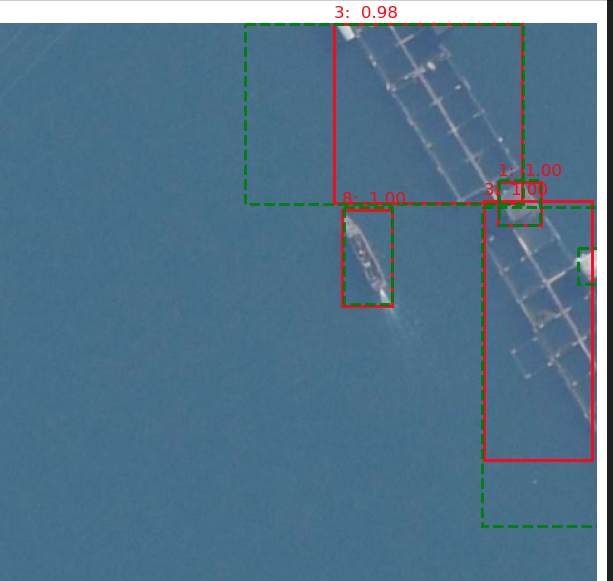

#### Баланс классов после  аугментации  

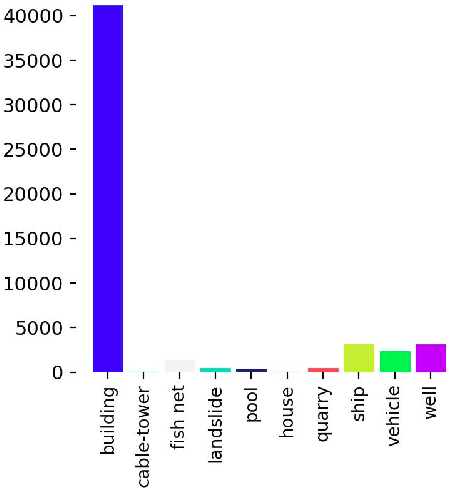



## 2. Датасет VEDAI  

https://paperswithcode.com/dataset/vedai  

#### Аугментация 2

In [ ]:
def aug_2():

    dataset = 0

    # Пути к датасету
    if dataset == 0:
        image_1 = 'dataset_VEDAI/set/image_1/'    
        input_images_dir = os.path.join(path_dataset, image_1)  
        labels_1 = 'dataset_VEDAI/set/target_1/'  
        input_labels_dir = os.path.join(path_dataset, labels_1) 
        
        image_2 = 'dataset_full_1/images/train/'   
        output_images_dir = os.path.join(path_dataset, image_2)  
        labels_2 = 'dataset_full_1/labels/train/'   
        output_labels_dir = os.path.join(path_dataset, labels_2)  
    elif dataset == 1:
        image_1 = 'dataset_UAVOD/datasets_split/images/test/'    
        input_images_dir = os.path.join(path_dataset, image_1)  
        labels_1 = 'dataset_UAVOD/datasets_split/labels/test/'  
        input_labels_dir = os.path.join(path_dataset, labels_1) 
        
        image_2 = 'dataset_full/images/test/'   
        output_images_dir = os.path.join(path_dataset, image_2)  
        labels_2 = 'dataset_full/labels/test/'   
        output_labels_dir = os.path.join(path_dataset, labels_2)  
    elif dataset == 2:
        image_1 = 'dataset_UAVOD/datasets_split/images/val/'    
        input_images_dir = os.path.join(path_dataset, image_1)  
        labels_1 = 'dataset_UAVOD/datasets_split/labels/val/'  
        input_labels_dir = os.path.join(path_dataset, labels_1) 
        
        image_2 = 'dataset_full/images/val/'   
        output_images_dir = os.path.join(path_dataset, image_2)  
        labels_2 = 'dataset_full/labels/val/'   
        output_labels_dir = os.path.join(path_dataset, labels_2)   



    generate_crops_for_dataset(
        image_dir=input_images_dir,  
        label_dir=input_labels_dir, 
        output_img_dir=output_images_dir,  
        output_lbl_dir=output_labels_dir, 
        crop_size=1024,         # Размер вырезки
        step=200,                # Шаг для сдвигов окна
        exclude_classes=[0]  # Исключенные классы
    )

# aug_2()


Обработка завершена! Все вырезки сохранены в /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_full_1/images/train/ и /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_full_1/labels/train/.


#### Баланс классов после добавления датасета VEDAI  

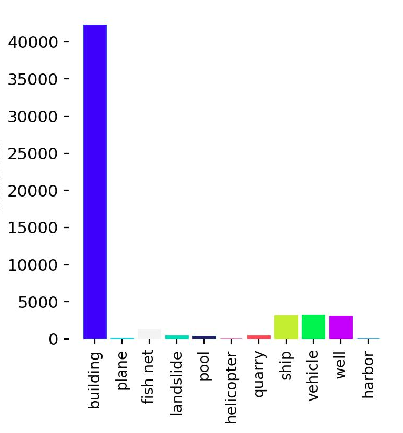 


In [18]:
import glob


labels_1 = 'dataset_full/labels/train/'  
labels_path = os.path.join(path_dataset, labels_1) 
 


label_paths = glob.glob(f"{labels_path}*.txt")
class_counts = {}

for label_path in label_paths:
    with open(label_path, "r") as file:
        lines = file.readlines()
    
    for line in lines:
        parts = line.split()
        if parts:  # Если строка не пустая
            class_id = int(parts[0])  # Получаем class_id
            class_counts[class_id] = class_counts.get(class_id, 0) + 1  # Считаем

print("Количество объектов по классам:")
# Вывод всех классов и их количества
for class_id, count in sorted(class_counts.items()):
    print(f"Класс {class_id}: {count} объектов")

Количество объектов по классам:
Класс 0: 66644 объектов
Класс 1: 6692 объектов
Класс 2: 1283 объектов
Класс 3: 394 объектов
Класс 4: 323 объектов
Класс 5: 27 объектов
Класс 6: 409 объектов
Класс 7: 14814 объектов
Класс 8: 75850 объектов
Класс 9: 3054 объектов
Класс 10: 3387 объектов


## 2. ДАТАСЕТ DOTA  

#### Конвертация аннотаций формата DOTA в YOLO

In [19]:
import os
import xml.etree.ElementTree as ET

# Получаем текущую рабочую папку  
current_directory = os.getcwd()  

path_dataset = os.path.join(current_directory, "dataset")

 
labels_1 = 'dataset_DOTA/dataset_DOTA/lables/'  
dota_labels_path = os.path.join(path_dataset, labels_1) 

In [20]:
import glob

label_paths = glob.glob(f"{dota_labels_path}*.txt")       # путь к аннотациям DOTA
class_names = set()

for label_path in label_paths:
    with open(label_path, "r") as file:
        lines = file.readlines()
    
    for line in lines:
        parts = line.strip().split()
        if len(parts) > 8:                               # Проверяем, есть ли название класса (оно 9-й элемент)
            class_name = parts[-2]                       # В DOTA имя класса идет перед difficulty
            class_names.add(class_name)

print("Классы датасета:")
print("Найденные классы в DOTA:", class_names)


Классы датасета:
Найденные классы в DOTA: set()




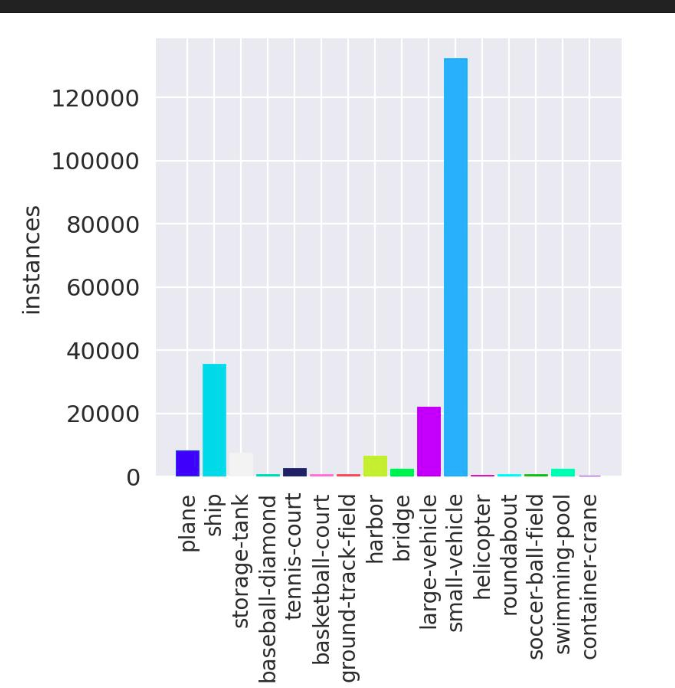

#### Конвертация в формат yolo  

In [21]:
# Конвертация в формат yolo
import os
import cv2

# Пути к файлам

image_2 = 'dataset_DOTA/dataset_DOTA/images/'   
images_path = os.path.join(path_dataset, image_2)  
labels_2 = 'dataset_DOTA/dataset_DOTA/yolo_labels/'   
yolo_labels_path = os.path.join(path_dataset, labels_2)  


os.makedirs(yolo_labels_path, exist_ok=True)

# Словарь классов DOTA  в YOLO 
dota_classes = {
    "plane": 0, "ship": 1, "storage-tank": 2, "baseball-diamond": 3, "tennis-court": 4,
    "basketball-court": 5, "ground-track-field": 6, "harbor": 7, "bridge": 8,
    "large-vehicle": 9, "small-vehicle": 10, "helicopter": 11, "roundabout": 12,
    "soccer-ball-field": 13, "swimming-pool": 14, "container-crane": 15
}

# Функция для конвертации аннотации
def convert_dota_to_yolo(dota_file, yolo_file, img_file):
    image = cv2.imread(img_file)
    if image is None:
        print(f"Ошибка: Не удалось загрузить изображение {img_file}")
        return
    
    img_h, img_w, _ = image.shape  #  высота ширина каналы

    with open(dota_file, "r") as f:
        lines = f.readlines()

    yolo_annotations = []

    for line in lines:
        parts = line.strip().split()
        if len(parts) < 9:        # Проверяем корректность строки
            continue

        # Читаем координаты 4 точек
        x1, y1, x2, y2, x3, y3, x4, y4 = map(float, parts[:8])
        class_name = parts[8]

        # Пропускаем неизвестные классы
        if class_name not in dota_classes:
            continue

        # YOLO-класс
        class_id = dota_classes[class_name]

        # Находим центр  бокса
        x_min = min(x1, x2, x3, x4)
        x_max = max(x1, x2, x3, x4)
        y_min = min(y1, y2, y3, y4)
        y_max = max(y1, y2, y3, y4)

        x_center = (x_min + x_max) / 2.0
        y_center = (y_min + y_max) / 2.0
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Нормализация 
        x_center /= img_w
        y_center /= img_h
        box_width /= img_w
        box_height /= img_h

        # Проверка на корректность размеров
        if box_width <= 0 or box_height <= 0:
            continue


        yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}\n")

    # Записываем  если есть боксы
    if yolo_annotations:
        with open(yolo_file, "w") as f:
            f.writelines(yolo_annotations)

def convert_to_yolo():
    for dota_file in os.listdir(dota_labels_path):
        if dota_file.endswith(".txt"):
            # Имя файла
            file_name = os.path.splitext(dota_file)[0]
            dota_file_path = os.path.join(dota_labels_path, dota_file)
            yolo_file_path = os.path.join(yolo_labels_path, dota_file)
            img_file_path = os.path.join(images_path, file_name + ".png")
            # Проверяем, существует ли изображение
            if not os.path.exists(img_file_path):
                print(f"Пропуск: Нет изображения для {dota_file}")
                continue
            # Конвертация
            convert_dota_to_yolo(dota_file_path, yolo_file_path, img_file_path)

    print("Конвертация завершена!")
# convert_to_yolo()

### Проверка  и исправление аннотаций

In [22]:
import os
import glob


image_2 = 'dataset_DOTA/dataset_DOTA/images/'   
image_dir = os.path.join(path_dataset, image_2)  
labels_2 = 'dataset_DOTA/dataset_DOTA/yolo_labels/'   
labels_dir = os.path.join(path_dataset, labels_2)  


def normalize_annotations():
    label_files = glob.glob(os.path.join(labels_dir, "*.txt"))

    for label_file in label_files:
        with open(label_file, "r") as f:
            lines = f.readlines()

        new_lines = []
        has_errors = False

        for line in lines:
            parts = line.strip().split()
            if len(parts) < 5:
                continue  

            class_id, x, y, w, h = map(float, parts[:5])

            # Проверяем координаты
            if x > 1 or y > 1 or w > 1 or h > 1:
                has_errors = True
                x, y, w, h = min(x, 1), min(y, 1), min(w, 1), min(h, 1)

            new_lines.append(f"{int(class_id)} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

        # Если были ошибки перезаписываем 
        if has_errors:
            with open(label_file, "w") as f:
                f.writelines(new_lines)
            print(f"Исправлено: {label_file}")
    print("Готово! Ошибки в аннотациях исправлены.")

# normalize_annotations()



### Количество объектов по классам

In [23]:
import glob

labels_1 = 'dataset_DOTA/dataset_DOTA/yolo_labels/'  
dota_labels_path = os.path.join(path_dataset, labels_1) 
 


label_paths = glob.glob(f"{dota_labels_path}*.txt")
class_counts = {}

for label_path in label_paths:
    with open(label_path, "r") as file:
        lines = file.readlines()
    
    for line in lines:
        parts = line.split()
        if parts:                                   # Если строка не пустая
            class_id = int(parts[0])                # Получаем class_id
            class_counts[class_id] = class_counts.get(class_id, 0) + 1  # Считаем

print("Количество объектов по классам:")
# Вывод всех классов и их количества
for class_id, count in sorted(class_counts.items()):
    print(f"Класс {class_id}: {count} объектов")

Количество объектов по классам:


### конвертируем в jpeg  и сжимаем изображения

In [24]:
import os
import glob
from PIL import Image

def convert_gpg1():
    image_2 = 'dataset_DOTA/dataset_DOTA/images/'   
    input_folder = os.path.join(path_dataset, image_2)  
    labels_2 = 'dataset_DOTA/dataset_DOTA/yolo_labels/'   
    labels_dir = os.path.join(path_dataset, labels_2)  
    image_3 = 'dataset_DOTA/dataset_DOTA/images_jpeg/'   
    output_folder = os.path.join(path_dataset, image_3)  


    os.makedirs(output_folder, exist_ok=True)

    image_paths = glob.glob(os.path.join(input_folder, "*.png"))

    for img_path in image_paths:
        img = Image.open(img_path).convert("RGB")  # Убираем прозрачность

        output_path = os.path.join(output_folder, os.path.basename(img_path).replace(".png", ".jpg"))
        img.save(output_path, "JPEG", quality=99)  # качество 

    print("PNG успешно конвертированы в JPEG!")

# convert_gpg1()()

### изменение разметки датасета DOTA  для датасета UAVOD

In [25]:
"""
    Изменяем разметку  DOTA  для UAVOD для дальейшего объединения
    убираем лишние классы. и переименонвываем классы
"""


# ===============    Словарь  классов для переименования
    # class_map = {
    #     0: 1,
    #     1: 7,
    #     7: 10,
    #     9: 11,
    #     10: 8,
    #     11: 12
    # }

# =======================     Классы, которые удаляем 
# remove_classes = {2, 3, 4, 5, 6, 8, 12, 13, 14, 15}
input_dir = "/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_DOTA/dataset_DOTA/yolo_labels/"
# cleaned1(class_map, remove_classes, input_dir)

In [26]:
import os
from glob import glob
# ===============    Словарь  классов для переименования
class_map = {
    8: 6,
    9: 4,
    10: 3,

}

# =======================     Классы, которые удаляем 
remove_classes = {22}
input_dir = "/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_full_3/labels/val/"
# cleaned1(class_map, remove_classes, input_dir)

#### Аугментация 3 

In [ ]:
def aug_3():

    dataset = 0

    # Пути к датасету
    if dataset == 0:
        image_1 = 'dataset_DOTA/set/2_image/'    
        input_images_dir = os.path.join(path_dataset, image_1)  
        labels_1 = 'dataset_DOTA/set/2_target/'  
        input_labels_dir = os.path.join(path_dataset, labels_1) 
      
        image_2 = 'dataset_full_1/images/train/'   
        output_images_dir = os.path.join(path_dataset, image_2)  
        labels_2 = 'dataset_full_1/labels/train/'   
        output_labels_dir = os.path.join(path_dataset, labels_2)  
    elif dataset == 1:
        image_1 = 'dataset_UAVOD/datasets_split/images/test/'    
        input_images_dir = os.path.join(path_dataset, image_1)  
        labels_1 = 'dataset_UAVOD/datasets_split/labels/test/'  
        input_labels_dir = os.path.join(path_dataset, labels_1) 
        
        image_2 = 'dataset_full/images/test/'   
        output_images_dir = os.path.join(path_dataset, image_2)  
        labels_2 = 'dataset_full/labels/test/'   
        output_labels_dir = os.path.join(path_dataset, labels_2)  
    elif dataset == 2:
        image_1 = 'dataset_UAVOD/datasets_split/images/val/'    
        input_images_dir = os.path.join(path_dataset, image_1)  
        labels_1 = 'dataset_UAVOD/datasets_split/labels/val/'  
        input_labels_dir = os.path.join(path_dataset, labels_1) 
        
        image_2 = 'dataset_full/images/val/'   
        output_images_dir = os.path.join(path_dataset, image_2)  
        labels_2 = 'dataset_full/labels/val/'   
        output_labels_dir = os.path.join(path_dataset, labels_2)   




    generate_crops_for_dataset(
        image_dir=input_images_dir,  
        label_dir=input_labels_dir, 
        output_img_dir=output_images_dir,  
        output_lbl_dir=output_labels_dir, 
        crop_size=1024,         # Размер вырезки
        step=200,                # Шаг для сдвигов окна
        exclude_classes=[0]  # Исключенные классы
    )

# aug_3()

Изображение /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_DOTA/set/2_image/P2638.jpg маленькое, обрезаем до минимальной стороны.
Изображение /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_DOTA/set/2_image/P2639.jpg маленькое, обрезаем до минимальной стороны.
Изображение /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_DOTA/set/2_image/P2626.jpg маленькое, обрезаем до минимальной стороны.
Обработка завершена! Все вырезки сохранены в /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_full_1/images/train/ и /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_full_1/labels/train/.


#### Баланс классов после добавления датасета DOTA  

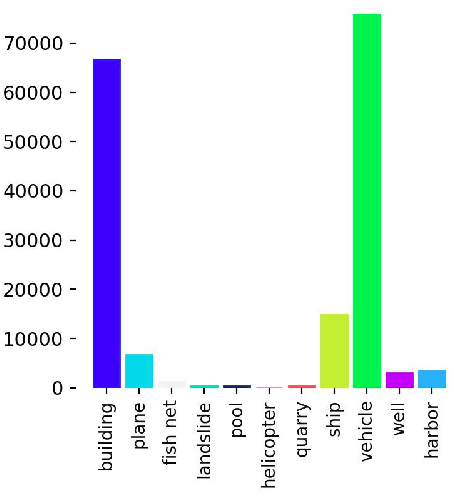  


## 3. Обработка датасета для custom_yolo

### удаление лишних классов
Были обработаны данные из датасетов UAVOD и DOTA  
Сохранены в разные каталоги для обучения моделей по отдельности и вместе  

In [ ]:
# фильтрует классы
import os
import shutil

def filter_yolo_dataset(
    img_dir,
    label_dir,
    output_img_dir="filtered_images",
    output_label_dir="filtered_targets"
):
    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)

    # Классы для фильтрации и замены
    allowed_classes = {8: 3, 7: 2, 1: 1, 11: 3}

    for label_file in os.listdir(label_dir):
        if not label_file.endswith(".txt"):
            continue

        label_path = os.path.join(label_dir, label_file)
        with open(label_path, "r") as f:
            lines = f.readlines()

        new_lines = []
        for line in lines:
            parts = line.strip().split()
            if not parts:
                continue

            class_id = int(parts[0])
            if class_id in allowed_classes:
                new_class_id = allowed_classes[class_id]
                new_line = " ".join([str(new_class_id)] + parts[1:])
                new_lines.append(new_line)

        # Сохраняем только если остались подходящие аннотации
        if new_lines:
            # Сохраняем отфильтрованные аннотации
            new_label_path = os.path.join(output_label_dir, label_file)
            with open(new_label_path, "w") as f:
                f.write("\n".join(new_lines) + "\n")

            # Копируем соответствующее изображение
            img_name = os.path.splitext(label_file)[0] + ".jpg"
            img_path = os.path.join(img_dir, img_name)
            out_img_path = os.path.join(output_img_dir, img_name)
            if os.path.exists(img_path):
                shutil.copy(img_path, out_img_path)


In [ ]:
img_dir="/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/dota/images/"
label_dir="/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/dota/target/"

img_dir="/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/datasets_original/image/"
label_dir="/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/datasets_original/target_yolo/"

# filter_yolo_dataset(img_dir=img_dir, label_dir=label_dir, output_img_dir="filtered_images", output_label_dir="filtered_targets")


### Объеденяем все классы

In [ ]:
# объеденим в один.
import os
def replacing_annotations():
    input_folder = "/home/maksim/develops/python/devsTraining/zala_task/dataset/custom_dataset/dataset_orign_2/target/"       
    output_folder = "target_fixed"  

    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.endswith(".txt"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            with open(input_path, "r") as f:
                lines = f.readlines()

            new_lines = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    parts[0] = "1"  # заменяем класс на 1
                    new_lines.append(" ".join(parts))

            # Сохраняем в новую папку
            with open(output_path, "w") as f:
                for line in new_lines:
                    f.write(line + "\n")

    print("Все классы заменены на 1 и сохранены в папку target_fixed/")

# replacing_annotations()

Все классы заменены на 1 и сохранены в папку target_fixed/


### Уменьшаем изображения (делаем квадратными)

In [ ]:
# Получаем текущую рабочую папку  
current_directory = os.getcwd()  

path_dataset = os.path.join(current_directory, "dataset")
image_1 = 'custom_dataset/dataset_orign_2/image/'    
input_images_dir = os.path.join(path_dataset, image_1)  
labels_1 = 'custom_dataset/dataset_orign_2/target/'  
input_labels_dir = os.path.join(path_dataset, labels_1) 

image_2 = 'custom_dataset/dataset_2/image/'   
output_images_dir = os.path.join(path_dataset, image_2)  
labels_2 = 'custom_dataset/dataset_2/target/'   
output_labels_dir = os.path.join(path_dataset, labels_2) 


def aug_5():
    generate_crops_for_dataset(
        image_dir=input_images_dir,  
        label_dir=input_labels_dir, 
        output_img_dir=output_images_dir,  
        output_lbl_dir=output_labels_dir, 
        crop_size=1200,          # Размер вырезки
        step=300,                # Шаг для сдвигов окна
        exclude_classes=[0, 5]   # Исключенные классы
    )

# aug_5()

Изображение /home/maksim/develops/python/devsTraining/zala_task/dataset/custom_dataset/dataset_orign_2/image/783.jpg слишком маленькое (ширина: 1048, высота: 1072).
Изображение /home/maksim/develops/python/devsTraining/zala_task/dataset/custom_dataset/dataset_orign_2/image/728.jpg слишком маленькое (ширина: 1160, высота: 1862).
Изображение /home/maksim/develops/python/devsTraining/zala_task/dataset/custom_dataset/dataset_orign_2/image/813.jpg слишком маленькое (ширина: 1144, высота: 1020).
Изображение /home/maksim/develops/python/devsTraining/zala_task/dataset/custom_dataset/dataset_orign_2/image/805.jpg слишком маленькое (ширина: 1056, высота: 950).
Изображение /home/maksim/develops/python/devsTraining/zala_task/dataset/custom_dataset/dataset_orign_2/image/791.jpg слишком маленькое (ширина: 1078, высота: 1024).
Изображение /home/maksim/develops/python/devsTraining/zala_task/dataset/custom_dataset/dataset_orign_2/image/603.jpg слишком маленькое (ширина: 1940, высота: 1092).
Изображение